<a href="https://colab.research.google.com/github/Bone-Age-Maisha/Bone_imp_1/blob/main/selecting_model_and_problem_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import numpy as np
import cv2
import os
import pandas as pd



In [17]:
import pandas as pd
train_dir = '/content/drive/MyDrive/hand_atlas/image'
df = pd.read_csv('/content/drive/MyDrive/hand_atlas/data.csv')

In [18]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [19]:
X_train = []
y_age = []
y_gender = []

#df = pd.read_csv('/raid/chenchao/code/BoneAge/BoneAge/data/Training.csv')
a = df.values
m = a.shape[0]

path = train_dir
k = 0
print ('Loading data set...')
k=1
for i in os.listdir(path):
  #print(i)
  if(i=="3131.jpg" or i=="4520.jpg" or i=="3187.jpg"):
    continue
  y_age.append(df.boneage[df.id == int(i[:-4])].tolist()[0])
  y_gender.append(df.gender[df.id == int(i[:-4])].tolist()[0])
  #print(i)
  img_path = path + "/"+i
  img = cv2.imread(img_path)
  #print(img.shape)
  #print (img_path)
  img = cv2.imread(img_path)
    #print (img_path)
    #if(img is not None):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(300,300))
  x = np.asarray(img, dtype=np.uint8)
  X_train.append(x)
  k=k+1

Loading data set...


In [20]:
!pip install visualization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing import image
import os

def softlabel(label,num_class):
    softlabel=np.zeros((len(label),num_class))
    ratio = 1.0/50
    for i in range(len(label)):
        for j in range(num_class):
            softlabel[i,j]=1.0 - ratio*np.abs(j-label[i])
    softlabel = np.maximum(softlabel,0)
    return softlabel


def ShowAttentionV1(model,image_path):
    file_list = os.listdir(image_path)
    file_list.sort()
    for filename in file_list:
        print (filename)
        filepath=image_path+filename
        image=load_image(filepath)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        layer=K.function([model.layers[0].input],[model.layers[196].output])
        FeatureMap=layer([image,gender])[0]
        print (FeatureMap.shape)
        FeatureMap = np.squeeze(FeatureMap, axis=0)
        FeatureMap = np.abs(FeatureMap)
        heatmap = np.mean(FeatureMap,axis=2)
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def GAPAttention(model,weights,image_path):
    file_list = os.listdir(train_dir)
    file_list.sort()
    for filename in file_list:
        filepath=image_path+filename
        print (filepath)
        image=load_image(filepath)
        print("gpa")
        print(image.shape)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        print("ok")
        layer=K.function([model.layers[0].input],[model.layers[1].get_output_at(-1),model.layers[-1].output])
        print("ok_1")
        GAP,prediction=layer([image])
        print("ok_2")
        GAP=np.squeeze(GAP,axis=0)
        print("ok_3")
        print (GAP.shape)
        print("ok_4")
        index = np.argmax(prediction)
        print("ok_5")
        print (index)
       # weight = weights[:,index]
        weight =np.mean(weights[:,index-5:index+5],axis=1)
        heatmap = np.zeros((GAP.shape[0],GAP.shape[1]))
        for k in range(GAP.shape[2]):
            heatmap = heatmap + weight[k]*GAP[:,:,k]
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def SaveImg(filename,filepath,heatmap):
    img = cv2.imread(filepath)
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
    AttentionImg =0.5* heatmap + img
    cv2.imwrite('/content/heat'+filename,heatmap)
    cv2.imwrite('/content/attention'+filename,AttentionImg)


def load_image(path):
    img = cv2.imread(path)
    print(img.shape)
    img = cv2.resize(img,(300,300))
    print(img.shape)
    x = np.asarray(img, dtype=np.float32)
   # img = image.load_img(path, target_size=(448, 448))
   # print (img.shape)
   # x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def TestMAE(model,test_data,test_label,test_gender):
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[3].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    predictions = np.array(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE
    
def DataAugment(x_train):
    x_train_Aug = np.zeros(x_train.shape)
    for i in range(x_train.shape[0]):
        for j in range(3):
            img = x_train[i,:,:,j]
            img = RandomMask(img)
            img = RandomMask(img)
            if np.random.random()>-1:
                x_train_Aug[i,:,:,j]=img 
            else:
                x_train_Aug[i,:,:,j]=x_train[i,:,:,j]
    return x_train_Aug


def RandomMask(img):
    m,n=img.shape
    m=int(m/6)
    n=int(n/6)
    i,j = np.random.randint(0,6,2)
    img[i*m:(i+1)*m,j*n:(j+1)*n]=np.random.random()
    return img

In [22]:
y = np.asarray(y_age)
gender = np.asarray(y_gender)
x=np.asarray(X_train, dtype=np.float32)
x=x/255
gender =2*( gender-0.5)
x_final = []
y_final = []
gender_final = []

# Shuffle images and split into train, validation and test sets
#random_no = np.random.choice(x.shape[0], size=x.shape[0], replace=False)
random_no = np.arange(x.shape[0])
#print(random_no)
np.random.seed(0)
np.random.shuffle(random_no)
for i in random_no:
    x_final.append(x[i,:,:,:])
    y_final.append(y[i])
    gender_final.append(gender[i])

x_final = np.asarray(x_final)
y_final = np.asarray(y_final)
gender_final = np.asarray(gender_final)
print (y_final[:50])
print (gender_final[:50])
k = 50 # Decides split count
x_test = x_final[:k,:,:,:]
y_test = y_final[:k]
gender_test = gender_final[:k]
x_valid = x_final[k:2*k,:,:,:]
y_valid = y_final[k:2*k]
gender_valid = gender_final[k:2*k]
x_train = x_final[2*k:,:,:,:]
y_train = y_final[2*k:]
gender_train = gender_final[2*k:]

## 
#y_test = keras.utils.to_categorical(y_test,240)
#y_train = keras.utils.to_categorical(y_train,240)
#y_valid = keras.utils.to_categorical(y_valid,240)
y_trains = softlabel(y_train,240)
y_valids = softlabel(y_valid,240)
y_tests = softlabel(y_test,240)
print (y_train)


print ('x_train shape:'+ str(x_train.shape))
print ('y_train shape:'+ str(y_train.shape))
print ('gender_train shape:'+ str(gender_train.shape))
print ('x_valid shape:'+ str(x_valid.shape))
print ('y_valid shape:'+ str(y_valid.shape))
print ('gender_valid shape:' + str(gender_valid.shape))
print ('x_test shape:'+ str(x_test.shape))
print ('y_test shape:'+ str(y_test.shape))

[ 86.2  129.1   57.76 178.7  110.1  101.5   49.02 199.4  139.9  151.5
 124.8   67.96 126.3  223.3  143.8   65.92  92.65  68.68  85.68 181.
 183.1  212.   106.3  183.6  204.7  149.7  121.2  138.2  162.2  117.4
 142.8  151.4  226.9  107.7   90.12 107.3  147.2  106.1  224.3  152.
  90.28 127.8  109.8   78.77 207.4  144.8  102.6   23.97  55.86 214.4 ]
[-1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.
 -1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.]
[177.3   11.97 191.2  ... 115.3  147.3  116.2 ]
x_train shape:(1286, 300, 300, 3)
y_train shape:(1286,)
gender_train shape:(1286,)
x_valid shape:(50, 300, 300, 3)
y_valid shape:(50,)
gender_valid shape:(50,)
x_test shape:(50, 300, 300, 3)
y_test shape:(50,)


In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda, Multiply
from keras import backend as K
import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras

batch_size = 16
epochs = 30


#model regresion

1.------------------------xception---------------------------------

In [24]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda,Multiply
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = Xception(weights='imagenet', include_top=False)
#for i,layer in enumerate(base_model.layers):
    #print (i,layer.name)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
##input_age = Input(shape=(1,),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
f = Dense(256, activation='relu')(f)
#f = Dense(240)(f)
#y=Flatten()(input_age)
#multiplied = tf.keras.layers.Multiply()([f, y])
predictions =Dense(1)(f)

  

model = Model(inputs=[input,input_gender], outputs=predictions)
#for i,layer in enumerate(model.layers):
    #print (i,layer.name)
model.summary()

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m1.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 10, 10, 2048)
(None, 2, 2, 256)
(None, 1056)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, None, None,   20861480    ['input1[0][0]']                 
                                2048)                                                             
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 256)    4718848     ['xception[0][0]']               
                                        

Epoch 1/10
81/81 [==============================] - 55s 586ms/step - loss: 28.4842 - MAE: 28.4842 - val_loss: 22.5500 - val_MAE: 22.5500
Epoch 2/10
81/81 [==============================] - 47s 582ms/step - loss: 15.8115 - MAE: 15.8115 - val_loss: 20.8820 - val_MAE: 20.8820
Epoch 3/10
81/81 [==============================] - 46s 573ms/step - loss: 13.9332 - MAE: 13.9332 - val_loss: 16.6284 - val_MAE: 16.6284
Epoch 4/10
81/81 [==============================] - 47s 580ms/step - loss: 12.6302 - MAE: 12.6302 - val_loss: 17.2237 - val_MAE: 17.2237
Epoch 5/10
81/81 [==============================] - 47s 583ms/step - loss: 12.7459 - MAE: 12.7459 - val_loss: 17.1869 - val_MAE: 17.1869
Epoch 6/10
81/81 [==============================] - 47s 582ms/step - loss: 10.4199 - MAE: 10.4199 - val_loss: 16.4527 - val_MAE: 16.4527
Epoch 7/10
81/81 [==============================] - 47s 579ms/step - loss: 10.9507 - MAE: 10.9507 - val_loss: 16.1641 - val_MAE: 16.1641
Epoch 8/10
81/81 [=======================

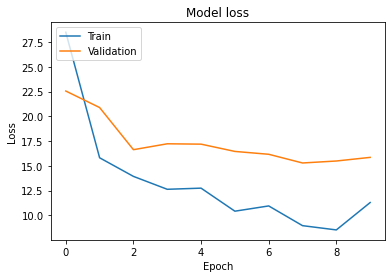

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    print (test_label)
    TestMAE = np.mean(np.abs(predictions-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_test,gender_test)
print(val)
#gender_test.shape

[array([[102.684616],
       [105.09068 ],
       [ 60.4571  ],
       [200.483   ],
       [114.86272 ],
       [ 95.520874],
       [ 53.808155],
       [202.50352 ],
       [143.91751 ],
       [131.0256  ],
       [121.43794 ],
       [ 60.95955 ],
       [ 93.4705  ],
       [209.32774 ],
       [160.82275 ],
       [ 70.88666 ],
       [ 82.24566 ],
       [ 83.99034 ],
       [112.68349 ],
       [183.87653 ],
       [179.03807 ],
       [206.6909  ],
       [102.75712 ],
       [187.8671  ],
       [191.66316 ],
       [135.33012 ],
       [108.64872 ],
       [144.07129 ],
       [163.71814 ],
       [ 94.82834 ],
       [116.450714],
       [128.89542 ],
       [198.54182 ],
       [111.04493 ],
       [100.319084],
       [ 83.82619 ],
       [142.7753  ],
       [106.18286 ],
       [214.12006 ],
       [132.78365 ],
       [104.21953 ],
       [133.41391 ],
       [109.28177 ],
       [ 77.60346 ],
       [196.56418 ],
       [153.32768 ],
       [ 91.26988 ],
       [ 19.

2.------------------------inception---------------------------------

In [29]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = InceptionV3(weights='imagenet', include_top=False)

input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(1)(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m2.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=50)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


87910968/87910968 [==============================] - 5s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(None, 8, 8, 2048)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 91s 315ms/step - loss: 28.8493 - MAE: 28.8493 - val_loss: 26.6404 - val_MAE: 26.6404
Epoch 2/10
81/81 [==============================] - 20s 248ms/step - loss: 17.1726 - MAE: 17.1726 - val_loss: 19.2251 - val_MAE: 19.2251
Epoch 3/10
81/81 [==============================] - 20s 245ms/step - loss: 16.7604 - MAE: 16.7604 - val_loss: 23.4947 - val_MAE: 23.4947
Epoch 4/10
81/81 [==============================] - 20s 246ms/step - loss: 15.6296 - MAE: 15.6296 - val_loss: 27.7135 - val_MAE: 27.7135
Epoch 5/10
81/81 [==============================] - 20s 246ms/step - loss: 11.8055 - MAE: 11.8055 - val_loss: 19.0605 - val_MAE: 19.0605
Epoch 6/10
81/81 [==============================] - 20s 245ms/step - loss: 11.0952 - MAE: 11.0952 - val_loss: 20.3074 - val_MAE: 20.3074
Epoch 7/10
81/81 [==============================] - 20s 246ms/step - loss: 12.0188 - MAE: 12.0188 - val_loss: 18.3874 - val_MAE:

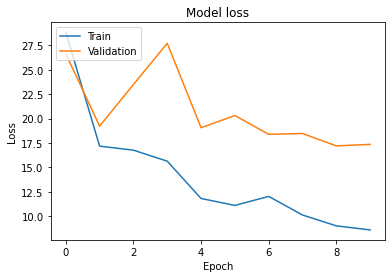

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    #print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predictions-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_test,gender_test)
print(val)
#gender_test.shape

[array([[ 89.007965],
       [102.36751 ],
       [ 58.676434],
       [177.28383 ],
       [110.44996 ],
       [ 88.93267 ],
       [ 51.650036],
       [186.67506 ],
       [137.40338 ],
       [117.054184],
       [135.46666 ],
       [ 61.5092  ],
       [ 76.22433 ],
       [193.15746 ],
       [151.85127 ],
       [ 72.035194],
       [ 73.38154 ],
       [ 79.15126 ],
       [ 99.15385 ],
       [188.58183 ],
       [168.83151 ],
       [185.32451 ],
       [ 85.80822 ],
       [184.12434 ],
       [180.30714 ],
       [144.80835 ],
       [ 97.249954],
       [146.04718 ],
       [166.83208 ],
       [ 90.32275 ],
       [116.84466 ],
       [130.38301 ],
       [189.84839 ],
       [ 81.91257 ],
       [ 78.47126 ],
       [ 71.63022 ],
       [142.63739 ],
       [ 98.76622 ],
       [182.60974 ],
       [136.27013 ],
       [ 88.190094],
       [137.57784 ],
       [ 81.62283 ],
       [ 73.78337 ],
       [175.82454 ],
       [160.51839 ],
       [ 77.08034 ],
       [ 26.

3.------------------------resnet---------------------------------

In [33]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = ResNet50(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions = Dense(1 )(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m3.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


94765736/94765736 [==============================] - 5s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(None, 10, 10, 2048)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 39s 377ms/step - loss: 28.1030 - MAE: 28.1030 - val_loss: 112.2412 - val_MAE: 112.2412
Epoch 2/10
81/81 [==============================] - 27s 330ms/step - loss: 16.0177 - MAE: 16.0177 - val_loss: 103.1265 - val_MAE: 103.1265
Epoch 3/10
81/81 [==============================] - 27s 327ms/step - loss: 14.9964 - MAE: 14.9964 - val_loss: 85.1425 - val_MAE: 85.1425
Epoch 4/10
81/81 [==============================] - 27s 328ms/step - loss: 12.4989 - MAE: 12.4989 - val_loss: 75.4132 - val_MAE: 75.4132
Epoch 5/10
81/81 [==============================] - 27s 329ms/step - loss: 11.7576 - MAE: 11.7576 - val_loss: 79.6459 - val_MAE: 79.6459
Epoch 6/10
81/81 [==============================] - 27s 327ms/step - loss: 12.4158 - MAE: 12.4158 - val_loss: 72.1980 - val_MAE: 72.1980
Epoch 7/10
81/81 [==============================] - 27s 328ms/step - loss: 10.2737 - MAE: 10.2737 - val_loss: 74.0951 - va

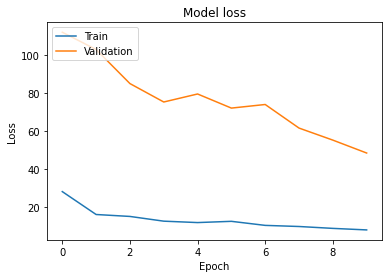

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    #print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predictions-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_test,gender_test)
print(val)
#gender_test.shape

[array([[ 94.28423 ],
       [ 99.87822 ],
       [ 90.72678 ],
       [124.95024 ],
       [103.52133 ],
       [ 93.23083 ],
       [ 79.42277 ],
       [129.17055 ],
       [103.388565],
       [100.73206 ],
       [106.68454 ],
       [ 92.168686],
       [ 90.24221 ],
       [111.487946],
       [106.0944  ],
       [ 94.655556],
       [ 92.44121 ],
       [ 90.97624 ],
       [ 93.792336],
       [110.98568 ],
       [108.848564],
       [133.54692 ],
       [ 95.22578 ],
       [117.94729 ],
       [115.577415],
       [104.17062 ],
       [ 94.43606 ],
       [101.995766],
       [106.78475 ],
       [ 80.615585],
       [ 92.4032  ],
       [104.60933 ],
       [109.11032 ],
       [ 92.358025],
       [ 90.09554 ],
       [ 97.76583 ],
       [102.674515],
       [ 98.703705],
       [120.48962 ],
       [101.239006],
       [ 97.63226 ],
       [101.88801 ],
       [ 87.880394],
       [ 89.86518 ],
       [ 99.42864 ],
       [108.17093 ],
       [ 89.2878  ],
       [ 72.

4.------------------------mobile---------------------------------

In [36]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions = Dense(1 )(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m4.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


9406464/9406464 [==============================] - 0s 0us/step


(None, 9, 9, 1280)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 25s 237ms/step - loss: 31.1015 - MAE: 31.1015 - val_loss: 71.5986 - val_MAE: 71.5986
Epoch 2/10
81/81 [==============================] - 17s 211ms/step - loss: 16.7838 - MAE: 16.7838 - val_loss: 52.8022 - val_MAE: 52.8022
Epoch 3/10
81/81 [==============================] - 17s 209ms/step - loss: 15.9589 - MAE: 15.9589 - val_loss: 42.1438 - val_MAE: 42.1438
Epoch 4/10
81/81 [==============================] - 17s 206ms/step - loss: 13.6167 - MAE: 13.6167 - val_loss: 39.4653 - val_MAE: 39.4653
Epoch 5/10
81/81 [==============================] - 17s 207ms/step - loss: 11.8812 - MAE: 11.8812 - val_loss: 27.9636 - val_MAE: 27.9636
Epoch 6/10
81/81 [==============================] - 17s 207ms/step - loss: 11.4175 - MAE: 11.4175 - val_loss: 22.4564 - val_MAE: 22.4564
Epoch 7/10
81/81 [==============================] - 17s 209ms/step - loss: 9.9872 - MAE: 9.9872 - val_loss: 22.1112 - val_MAE: 2

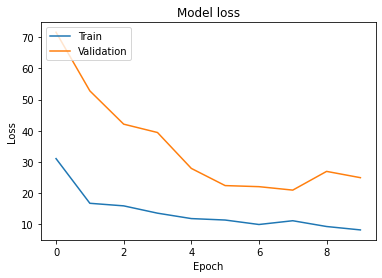

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    print (test_label)
    TestMAE = np.mean(np.abs(predictions-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_test,gender_test)
print(val)
#gender_test.shape

[array([[126.03241 ],
       [123.931915],
       [ 91.26793 ],
       [197.08026 ],
       [154.2716  ],
       [114.365074],
       [ 68.22073 ],
       [209.76364 ],
       [154.67383 ],
       [165.05751 ],
       [177.75005 ],
       [114.80784 ],
       [129.44281 ],
       [202.12065 ],
       [164.35544 ],
       [ 88.90781 ],
       [105.06391 ],
       [125.53028 ],
       [129.66937 ],
       [191.53671 ],
       [199.07869 ],
       [206.17729 ],
       [132.57256 ],
       [184.03033 ],
       [207.93736 ],
       [173.87285 ],
       [129.78822 ],
       [165.28625 ],
       [172.79622 ],
       [ 77.64644 ],
       [136.76839 ],
       [158.9728  ],
       [183.26117 ],
       [137.6314  ],
       [120.59768 ],
       [ 96.61492 ],
       [181.14043 ],
       [148.68535 ],
       [180.2752  ],
       [159.99107 ],
       [119.52217 ],
       [165.76001 ],
       [141.19017 ],
       [ 84.624565],
       [166.46231 ],
       [177.83173 ],
       [111.50595 ],
       [ 58.

5.------------------------inres---------------------------------

In [39]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions = Dense(1 )(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m5.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


219055592/219055592 [==============================] - 12s 0us/step


(None, 8, 8, 1536)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 76s 671ms/step - loss: 29.1579 - MAE: 29.1579 - val_loss: 21.9943 - val_MAE: 21.9943
Epoch 2/10
81/81 [==============================] - 47s 576ms/step - loss: 17.2834 - MAE: 17.2834 - val_loss: 42.2221 - val_MAE: 42.2221
Epoch 3/10
81/81 [==============================] - 47s 582ms/step - loss: 13.7085 - MAE: 13.7085 - val_loss: 28.8222 - val_MAE: 28.8222
Epoch 4/10
81/81 [==============================] - 47s 578ms/step - loss: 11.3037 - MAE: 11.3037 - val_loss: 19.2887 - val_MAE: 19.2887
Epoch 5/10
81/81 [==============================] - 47s 581ms/step - loss: 11.1450 - MAE: 11.1450 - val_loss: 17.9324 - val_MAE: 17.9324
Epoch 6/10
81/81 [==============================] - 47s 581ms/step - loss: 10.2713 - MAE: 10.2713 - val_loss: 16.7766 - val_MAE: 16.7766
Epoch 7/10
81/81 [==============================] - 47s 581ms/step - loss: 9.6069 - MAE: 9.6069 - val_loss: 20.0903 - val_MAE: 2

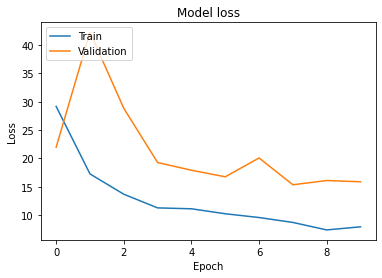

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [41]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    #predict_label = np.argmax(predictions,axis=1)
    #test_label = np.argmax(test_label,axis=1)
    #print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predictions-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_test,gender_test)
print(val)
#gender_test.shape

[array([[ 92.34558 ],
       [ 93.23527 ],
       [ 55.520195],
       [183.62704 ],
       [106.99354 ],
       [ 86.144905],
       [ 44.627705],
       [199.87415 ],
       [144.50111 ],
       [133.06915 ],
       [126.40394 ],
       [ 57.414505],
       [ 93.69293 ],
       [209.07263 ],
       [149.65962 ],
       [ 63.933537],
       [ 63.828796],
       [ 69.004845],
       [108.333855],
       [187.1767  ],
       [188.80087 ],
       [196.3005  ],
       [ 95.76556 ],
       [190.15952 ],
       [186.82501 ],
       [137.59421 ],
       [ 91.196014],
       [147.14497 ],
       [162.07166 ],
       [ 95.05599 ],
       [108.84294 ],
       [150.31024 ],
       [197.48065 ],
       [ 88.25938 ],
       [ 92.287834],
       [ 80.84161 ],
       [142.98064 ],
       [102.70334 ],
       [205.53726 ],
       [137.30875 ],
       [ 81.00219 ],
       [134.7181  ],
       [ 87.581635],
       [ 59.140324],
       [176.66267 ],
       [161.28241 ],
       [ 76.11026 ],
       [ 26.

6.------------------------den201---------------------------------

In [42]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions = Dense(1 )(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m6.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


74836368/74836368 [==============================] - 4s 0us/step


(None, 9, 9, 1920)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 86s 696ms/step - loss: 25.9185 - MAE: 25.9185 - val_loss: 68.9332 - val_MAE: 68.9332
Epoch 2/10
81/81 [==============================] - 41s 506ms/step - loss: 16.2421 - MAE: 16.2421 - val_loss: 35.2527 - val_MAE: 35.2527
Epoch 3/10
81/81 [==============================] - 41s 512ms/step - loss: 14.2109 - MAE: 14.2109 - val_loss: 17.6235 - val_MAE: 17.6235
Epoch 4/10
81/81 [==============================] - 41s 507ms/step - loss: 14.1727 - MAE: 14.1727 - val_loss: 17.6843 - val_MAE: 17.6843
Epoch 5/10
81/81 [==============================] - 41s 508ms/step - loss: 11.1731 - MAE: 11.1731 - val_loss: 19.0242 - val_MAE: 19.0242
Epoch 6/10
81/81 [==============================] - 41s 509ms/step - loss: 9.2526 - MAE: 9.2526 - val_loss: 19.7910 - val_MAE: 19.7910
Epoch 7/10
81/81 [==============================] - 41s 512ms/step - loss: 10.0094 - MAE: 10.0094 - val_loss: 15.6573 - val_MAE: 1

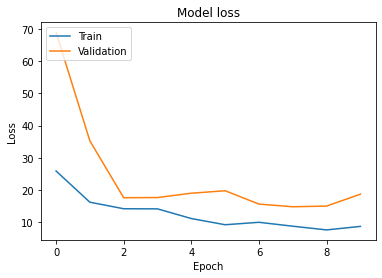

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    #predict_label = np.argmax(predictions,axis=1)
    #test_label = np.argmax(test_label,axis=1)
    #print (predict_label)
    #print (test_label)
    TestMAE = np.mean(np.abs(predictions-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_test,gender_test)
print(val)
#gender_test.shape

[array([[ 80.73876 ],
       [104.537346],
       [ 63.350796],
       [172.33524 ],
       [104.741035],
       [ 84.286896],
       [ 49.221703],
       [187.89842 ],
       [127.21207 ],
       [129.92387 ],
       [125.17837 ],
       [ 59.698875],
       [ 91.25712 ],
       [211.50966 ],
       [139.24348 ],
       [ 67.913666],
       [ 68.94258 ],
       [ 69.048256],
       [ 91.30661 ],
       [173.92104 ],
       [157.81949 ],
       [212.14667 ],
       [ 91.150696],
       [179.91014 ],
       [170.97702 ],
       [128.06209 ],
       [ 88.24484 ],
       [130.30553 ],
       [147.3761  ],
       [100.58635 ],
       [100.25478 ],
       [125.09219 ],
       [187.34125 ],
       [ 89.74809 ],
       [ 85.56167 ],
       [ 68.89122 ],
       [121.9912  ],
       [ 86.551   ],
       [210.30193 ],
       [120.64505 ],
       [ 84.72533 ],
       [135.16692 ],
       [ 91.55567 ],
       [ 66.863304],
       [183.24219 ],
       [137.07948 ],
       [ 79.60869 ],
       [ 18.

7.------------------------eff---------------------------------

In [45]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB4

base_model = EfficientNetB4(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions = Dense(1 )(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m6.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


71686520/71686520 [==============================] - 4s 0us/step


(None, 9, 9, 1792)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 86s 794ms/step - loss: 32.5950 - MAE: 32.5950 - val_loss: 152.5389 - val_MAE: 152.5389
Epoch 2/10
81/81 [==============================] - 57s 703ms/step - loss: 19.0631 - MAE: 19.0631 - val_loss: 142.7193 - val_MAE: 142.7193
Epoch 3/10
81/81 [==============================] - 58s 714ms/step - loss: 17.0899 - MAE: 17.0899 - val_loss: 136.2624 - val_MAE: 136.2624
Epoch 4/10
81/81 [==============================] - 57s 704ms/step - loss: 15.0810 - MAE: 15.0810 - val_loss: 127.5804 - val_MAE: 127.5804
Epoch 5/10
81/81 [==============================] - 57s 707ms/step - loss: 12.7380 - MAE: 12.7380 - val_loss: 97.7055 - val_MAE: 97.7055
Epoch 6/10
81/81 [==============================] - 57s 709ms/step - loss: 12.3598 - MAE: 12.3598 - val_loss: 86.0772 - val_MAE: 86.0772
Epoch 7/10
81/81 [==============================] - 58s 711ms/step - loss: 11.3021 - MAE: 11.3021 - val_loss: 72.9899 - 

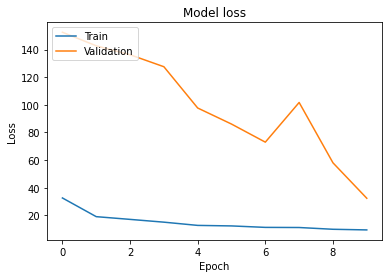

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    #predict_label = np.argmax(predictions,axis=1)
    #test_label = np.argmax(test_label,axis=1)
    #print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predictions-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_test,gender_test)
print(val)
#gender_test.shape

[array([[ 89.97889 ],
       [138.8396  ],
       [ 87.502205],
       [180.2235  ],
       [141.47006 ],
       [109.758545],
       [102.54215 ],
       [181.17755 ],
       [105.647865],
       [144.79056 ],
       [134.73712 ],
       [111.29367 ],
       [136.66248 ],
       [175.9628  ],
       [156.4168  ],
       [104.41355 ],
       [106.79719 ],
       [ 99.46779 ],
       [100.884995],
       [162.2605  ],
       [143.11992 ],
       [178.30322 ],
       [130.3517  ],
       [166.59871 ],
       [171.06718 ],
       [134.0685  ],
       [111.5349  ],
       [140.47841 ],
       [117.06113 ],
       [ 99.85656 ],
       [117.480064],
       [125.831406],
       [169.03535 ],
       [107.99348 ],
       [ 85.824936],
       [121.46862 ],
       [127.33607 ],
       [133.73424 ],
       [181.39859 ],
       [106.3411  ],
       [118.98394 ],
       [126.56922 ],
       [ 85.38008 ],
       [100.68257 ],
       [158.30742 ],
       [127.08603 ],
       [114.36508 ],
       [104.

#model softmax regression

1.------------------------xception---------------------------------

In [48]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda,Multiply
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = Xception(weights='imagenet', include_top=False)
#for i,layer in enumerate(base_model.layers):
    #print (i,layer.name)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
##input_age = Input(shape=(1,),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
f = Dense(256, activation='relu')(f)
#f = Dense(240)(f)
#y=Flatten()(input_age)
#multiplied = tf.keras.layers.Multiply()([f, y])
predictions =Dense(240)(f)

  

model = Model(inputs=[input,input_gender], outputs=predictions)
#for i,layer in enumerate(model.layers):
    #print (i,layer.name)
model.summary()

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m1.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 10, 10, 2048)
(None, 2, 2, 256)
(None, 1056)
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, None, None,   20861480    ['input1[0][0]']                 
                                2048)                                                             
                                                                                                  
 conv2d_317 (Conv2D)            (None, 8, 8, 256)    4718848     ['xception[0][0]']               
                                       

Epoch 1/10
81/81 [==============================] - 53s 592ms/step - loss: 0.2183 - MAE: 0.2183 - val_loss: 0.2049 - val_MAE: 0.2049
Epoch 2/10
81/81 [==============================] - 46s 562ms/step - loss: 0.2014 - MAE: 0.2014 - val_loss: 0.2040 - val_MAE: 0.2040
Epoch 3/10
81/81 [==============================] - 44s 545ms/step - loss: 0.2012 - MAE: 0.2012 - val_loss: 0.2038 - val_MAE: 0.2038
Epoch 4/10
81/81 [==============================] - 44s 538ms/step - loss: 0.2011 - MAE: 0.2011 - val_loss: 0.2038 - val_MAE: 0.2038
Epoch 5/10
81/81 [==============================] - 44s 539ms/step - loss: 0.2010 - MAE: 0.2010 - val_loss: 0.2035 - val_MAE: 0.2035
Epoch 6/10
81/81 [==============================] - 44s 539ms/step - loss: 0.2009 - MAE: 0.2009 - val_loss: 0.2033 - val_MAE: 0.2033
Epoch 7/10
81/81 [==============================] - 44s 538ms/step - loss: 0.2008 - MAE: 0.2008 - val_loss: 0.2031 - val_MAE: 0.2031
Epoch 8/10
81/81 [==============================] - 43s 532ms/step - 

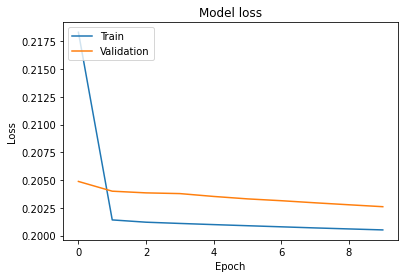

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[ 9.7427219e-06,  2.6950513e-05,  2.6583519e-05, ...,
        -1.3956313e-05,  2.6177269e-05,  1.7588354e-06],
       [ 9.7427219e-06,  2.6950513e-05,  2.6583519e-05, ...,
        -1.3956313e-05,  2.6177269e-05,  1.7588354e-06],
       [ 9.7427219e-06,  2.6950513e-05,  2.6583519e-05, ...,
        -1.3956313e-05,  2.6177269e-05,  1.7588354e-06],
       ...,
       [ 9.7427219e-06,  2.6950513e-05,  2.6583519e-05, ...,
        -1.3956313e-05,  2.6177269e-05,  1.7588354e-06],
       [ 9.7427219e-06,  2.6950513e-05,  2.6583519e-05, ...,
        -1.3956313e-05,  2.6177269e-05,  1.7588354e-06],
       [ 9.7427219e-06,  2.6950513e-05,  2.6583519e-05, ...,
        -1.3956313e-05,  2.6177269e-05,  1.7588354e-06]], dtype=float32)]
[[[ 9.7427219e-06  2.6950513e-05  2.6583519e-05 ... -1.3956313e-05
    2.6177269e-05  1.7588354e-06]
  [ 9.7427219e-06  2.6950513e-05  2.6583519e-05 ... -1.3956313e-05
    2.6177269e-05  1.7588354e-06]
  [ 9.7427219e-06  2.6950513e-05  2.6583519e-05 ... -1.39563

2.------------------------inception---------------------------------

In [51]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = InceptionV3(weights='imagenet', include_top=False)

input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240)(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m2.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 8, 8, 2048)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 30s 263ms/step - loss: 0.2880 - MAE: 0.2880 - val_loss: 0.2581 - val_MAE: 0.2581
Epoch 2/10
81/81 [==============================] - 20s 248ms/step - loss: 0.1777 - MAE: 0.1777 - val_loss: 0.1949 - val_MAE: 0.1949
Epoch 3/10
81/81 [==============================] - 20s 246ms/step - loss: 0.1341 - MAE: 0.1341 - val_loss: 0.1525 - val_MAE: 0.1525
Epoch 4/10
81/81 [==============================] - 20s 243ms/step - loss: 0.1046 - MAE: 0.1046 - val_loss: 0.1381 - val_MAE: 0.1381
Epoch 5/10
81/81 [==============================] - 20s 245ms/step - loss: 0.0907 - MAE: 0.0907 - val_loss: 0.1212 - val_MAE: 0.1212
Epoch 6/10
81/81 [==============================] - 20s 246ms/step - loss: 0.0763 - MAE: 0.0763 - val_loss: 0.1164 - val_MAE: 0.1164
Epoch 7/10
81/81 [==============================] - 20s 245ms/step - loss: 0.0725 - MAE: 0.0725 - val_loss: 0.1149 - val_MAE: 0.1149
Epoch 8/10
81/81 [=

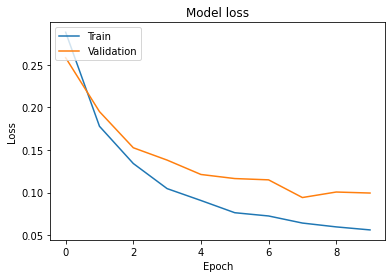

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [53]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[-0.00242161,  0.02193946,  0.02274354, ...,  0.00195928,
         0.02796426,  0.03816719],
       [-0.00348906,  0.01535618,  0.05331929, ..., -0.0148801 ,
         0.009816  , -0.00676459],
       [ 0.01093643, -0.00175092, -0.02119781, ...,  0.01437474,
         0.04056164,  0.01608729],
       ...,
       [ 0.69308376,  0.74140424,  0.77489316, ..., -0.00123573,
        -0.0368823 , -0.04003756],
       [-0.00958752,  0.00189587,  0.02083813, ...,  0.03251733,
         0.01597525,  0.01780169],
       [-0.01639217,  0.01214129,  0.02761785, ...,  0.19091177,
         0.220506  ,  0.16649485]], dtype=float32)]
[[[-0.00242161  0.02193946  0.02274354 ...  0.00195928  0.02796426
    0.03816719]
  [-0.00348906  0.01535618  0.05331929 ... -0.0148801   0.009816
   -0.00676459]
  [ 0.01093643 -0.00175092 -0.02119781 ...  0.01437474  0.04056164
    0.01608729]
  ...
  [ 0.69308376  0.74140424  0.77489316 ... -0.00123573 -0.0368823
   -0.04003756]
  [-0.00958752  0.00189587  0.02083

3.------------------------resnet---------------------------------

In [54]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = ResNet50(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240)(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m3.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 10, 10, 2048)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 34s 344ms/step - loss: 0.3440 - MAE: 0.3440 - val_loss: 0.5485 - val_MAE: 0.5485
Epoch 2/10
81/81 [==============================] - 27s 333ms/step - loss: 0.1896 - MAE: 0.1896 - val_loss: 0.2621 - val_MAE: 0.2621
Epoch 3/10
81/81 [==============================] - 26s 327ms/step - loss: 0.1518 - MAE: 0.1518 - val_loss: 0.2892 - val_MAE: 0.2892
Epoch 4/10
81/81 [==============================] - 26s 327ms/step - loss: 0.1280 - MAE: 0.1280 - val_loss: 0.2219 - val_MAE: 0.2219
Epoch 5/10
81/81 [==============================] - 26s 327ms/step - loss: 0.1029 - MAE: 0.1029 - val_loss: 0.2235 - val_MAE: 0.2235
Epoch 6/10
81/81 [==============================] - 26s 327ms/step - loss: 0.0896 - MAE: 0.0896 - val_loss: 0.2211 - val_MAE: 0.2211
Epoch 7/10
81/81 [==============================] - 26s 327ms/step - loss: 0.0819 - MAE: 0.0819 - val_loss: 0.2163 - val_MAE: 0.2163
Epoch 8/10
81/81 

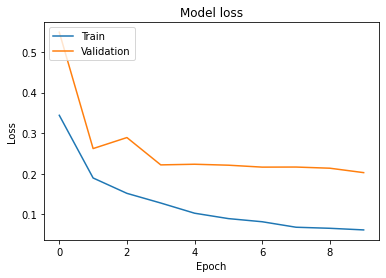

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[ 0.02760589,  0.04623172, -0.02650497, ...,  0.00787039,
         0.03086916, -0.00266104],
       [ 0.019901  ,  0.0169434 ,  0.01173235, ...,  0.00629138,
         0.01844241, -0.00344319],
       [-0.00101562,  0.06595865, -0.01539815, ..., -0.02895627,
         0.06390355,  0.0342086 ],
       ...,
       [-0.04127486,  0.06487485, -0.01607348, ..., -0.00825804,
         0.02320402,  0.03037965],
       [-0.02151608,  0.09064414, -0.01521946, ...,  0.01255327,
         0.02911037,  0.02175833],
       [ 0.02677224,  0.04479479, -0.0114626 , ...,  0.06287973,
         0.1302615 ,  0.05308552]], dtype=float32)]
[[[ 0.02760589  0.04623172 -0.02650497 ...  0.00787039  0.03086916
   -0.00266104]
  [ 0.019901    0.0169434   0.01173235 ...  0.00629138  0.01844241
   -0.00344319]
  [-0.00101562  0.06595865 -0.01539815 ... -0.02895627  0.06390355
    0.0342086 ]
  ...
  [-0.04127486  0.06487485 -0.01607348 ... -0.00825804  0.02320402
    0.03037965]
  [-0.02151608  0.09064414 -0.01

4.------------------------mobile---------------------------------

In [57]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240)(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m4.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 9, 9, 1280)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 22s 219ms/step - loss: 0.4989 - MAE: 0.4989 - val_loss: 0.8170 - val_MAE: 0.8170
Epoch 2/10
81/81 [==============================] - 17s 211ms/step - loss: 0.2171 - MAE: 0.2171 - val_loss: 0.5882 - val_MAE: 0.5882
Epoch 3/10
81/81 [==============================] - 17s 210ms/step - loss: 0.1886 - MAE: 0.1886 - val_loss: 0.4818 - val_MAE: 0.4818
Epoch 4/10
81/81 [==============================] - 17s 208ms/step - loss: 0.1580 - MAE: 0.1580 - val_loss: 0.4026 - val_MAE: 0.4026
Epoch 5/10
81/81 [==============================] - 17s 208ms/step - loss: 0.1386 - MAE: 0.1386 - val_loss: 0.3390 - val_MAE: 0.3390
Epoch 6/10
81/81 [==============================] - 17s 208ms/step - loss: 0.1200 - MAE: 0.1200 - val_loss: 0.2953 - val_MAE: 0.2953
Epoch 7/10
81/81 [==============================] - 17s 210ms/step - loss: 0.1061 - MAE: 0.1061 - val_loss: 0.2816 - val_MAE: 0.2816
Epoch 8/10
81/81 [=

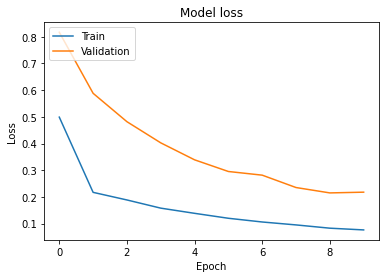

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [59]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[ 0.02933555, -0.01817966, -0.01371889, ...,  0.08359307,
         0.07279454, -0.10282555],
       [ 0.14842248,  0.05088124,  0.08104468, ..., -0.00644339,
         0.34747648,  0.05210375],
       [-0.01827911, -0.2152895 , -0.08353485, ..., -0.1296112 ,
         0.41189206, -0.03246297],
       ...,
       [ 0.41044027,  0.230525  ,  0.2909469 , ..., -0.05757793,
         0.11916912,  0.14468403],
       [ 0.23029262,  0.10438707,  0.12981474, ..., -0.2984974 ,
         0.09003817, -0.17510512],
       [ 0.19462886,  0.13681938,  0.16225232, ...,  0.5385575 ,
         0.38255048,  0.57357126]], dtype=float32)]
[[[ 0.02933555 -0.01817966 -0.01371889 ...  0.08359307  0.07279454
   -0.10282555]
  [ 0.14842248  0.05088124  0.08104468 ... -0.00644339  0.34747648
    0.05210375]
  [-0.01827911 -0.2152895  -0.08353485 ... -0.1296112   0.41189206
   -0.03246297]
  ...
  [ 0.41044027  0.230525    0.2909469  ... -0.05757793  0.11916912
    0.14468403]
  [ 0.23029262  0.10438707  0.12

5.------------------------inres---------------------------------

In [60]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240)(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m5.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 8, 8, 1536)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 69s 624ms/step - loss: 0.2681 - MAE: 0.2681 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 2/10
81/81 [==============================] - 47s 576ms/step - loss: 0.1806 - MAE: 0.1806 - val_loss: 0.1982 - val_MAE: 0.1982
Epoch 3/10
81/81 [==============================] - 47s 579ms/step - loss: 0.1385 - MAE: 0.1385 - val_loss: 0.1616 - val_MAE: 0.1616
Epoch 4/10
81/81 [==============================] - 47s 579ms/step - loss: 0.1090 - MAE: 0.1090 - val_loss: 0.1366 - val_MAE: 0.1366
Epoch 5/10
81/81 [==============================] - 47s 578ms/step - loss: 0.0921 - MAE: 0.0921 - val_loss: 0.1211 - val_MAE: 0.1211
Epoch 6/10
81/81 [==============================] - 47s 577ms/step - loss: 0.0772 - MAE: 0.0772 - val_loss: 0.1232 - val_MAE: 0.1232
Epoch 7/10
81/81 [==============================] - 47s 578ms/step - loss: 0.0690 - MAE: 0.0690 - val_loss: 0.1081 - val_MAE: 0.1081
Epoch 8/10
81/81 [=

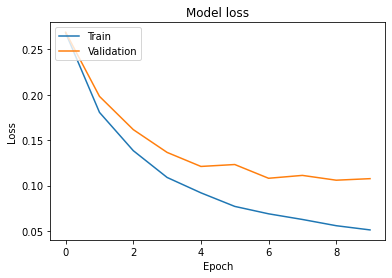

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [62]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[ 0.00469802, -0.00097051, -0.03067896, ..., -0.04672214,
        -0.00954808,  0.03014527],
       [ 0.02409305,  0.0196684 ,  0.00642341, ..., -0.03262457,
         0.01722093, -0.00470405],
       [-0.00141449, -0.01000596, -0.0358343 , ...,  0.00914815,
        -0.04944964, -0.00146608],
       ...,
       [ 0.45809856,  0.52466655,  0.5063424 , ..., -0.03074686,
         0.02633773,  0.0101441 ],
       [-0.0040701 ,  0.00207303, -0.01535123, ..., -0.01431956,
        -0.01077877,  0.00613324],
       [ 0.09243172, -0.02559393,  0.01626751, ..., -0.00347315,
         0.02511612,  0.03112345]], dtype=float32)]
[[[ 0.00469802 -0.00097051 -0.03067896 ... -0.04672214 -0.00954808
    0.03014527]
  [ 0.02409305  0.0196684   0.00642341 ... -0.03262457  0.01722093
   -0.00470405]
  [-0.00141449 -0.01000596 -0.0358343  ...  0.00914815 -0.04944964
   -0.00146608]
  ...
  [ 0.45809856  0.52466655  0.5063424  ... -0.03074686  0.02633773
    0.0101441 ]
  [-0.0040701   0.00207303 -0.01

6.------------------------den201---------------------------------

In [63]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240)(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m6.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 9, 9, 1920)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 64s 546ms/step - loss: 0.3142 - MAE: 0.3142 - val_loss: 0.3046 - val_MAE: 0.3046
Epoch 2/10
81/81 [==============================] - 41s 509ms/step - loss: 0.1569 - MAE: 0.1569 - val_loss: 0.2377 - val_MAE: 0.2377
Epoch 3/10
81/81 [==============================] - 41s 508ms/step - loss: 0.1230 - MAE: 0.1230 - val_loss: 0.1951 - val_MAE: 0.1951
Epoch 4/10
81/81 [==============================] - 41s 510ms/step - loss: 0.1046 - MAE: 0.1046 - val_loss: 0.1880 - val_MAE: 0.1880
Epoch 5/10
81/81 [==============================] - 41s 509ms/step - loss: 0.0906 - MAE: 0.0906 - val_loss: 0.1426 - val_MAE: 0.1426
Epoch 6/10
81/81 [==============================] - 41s 510ms/step - loss: 0.0814 - MAE: 0.0814 - val_loss: 0.1219 - val_MAE: 0.1219
Epoch 7/10
81/81 [==============================] - 41s 508ms/step - loss: 0.0697 - MAE: 0.0697 - val_loss: 0.1151 - val_MAE: 0.1151
Epoch 8/10
81/81 [=

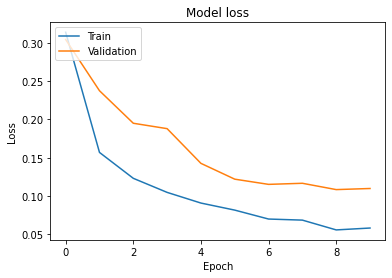

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [65]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[-0.00696431,  0.01454504, -0.01947005, ..., -0.03816537,
         0.00761211, -0.03311308],
       [-0.01460892,  0.01916808, -0.02283543, ..., -0.00604018,
         0.03799834, -0.00419502],
       [ 0.06085468,  0.09328073,  0.05033323, ..., -0.02936604,
         0.02206496,  0.02129307],
       ...,
       [ 0.5283565 ,  0.5190901 ,  0.5626262 , ...,  0.02819656,
         0.00462987, -0.02722909],
       [ 0.03144438,  0.06256942, -0.01678849, ...,  0.0175172 ,
        -0.0188509 , -0.00855335],
       [-0.02844078,  0.0490096 , -0.04559337, ...,  0.25595948,
         0.27154347,  0.30251873]], dtype=float32)]
[[[-0.00696431  0.01454504 -0.01947005 ... -0.03816537  0.00761211
   -0.03311308]
  [-0.01460892  0.01916808 -0.02283543 ... -0.00604018  0.03799834
   -0.00419502]
  [ 0.06085468  0.09328073  0.05033323 ... -0.02936604  0.02206496
    0.02129307]
  ...
  [ 0.5283565   0.5190901   0.5626262  ...  0.02819656  0.00462987
   -0.02722909]
  [ 0.03144438  0.06256942 -0.01

7.------------------------eff---------------------------------

In [66]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB4

base_model = EfficientNetB4(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240)(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m6.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 9, 9, 1792)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 80s 743ms/step - loss: 0.3445 - MAE: 0.3445 - val_loss: 0.2646 - val_MAE: 0.2646
Epoch 2/10
81/81 [==============================] - 57s 703ms/step - loss: 0.2264 - MAE: 0.2264 - val_loss: 0.2593 - val_MAE: 0.2593
Epoch 3/10
81/81 [==============================] - 57s 705ms/step - loss: 0.1944 - MAE: 0.1944 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 4/10
81/81 [==============================] - 57s 702ms/step - loss: 0.1614 - MAE: 0.1614 - val_loss: 0.2525 - val_MAE: 0.2525
Epoch 5/10
81/81 [==============================] - 57s 702ms/step - loss: 0.1436 - MAE: 0.1436 - val_loss: 0.2558 - val_MAE: 0.2558
Epoch 6/10
81/81 [==============================] - 57s 708ms/step - loss: 0.1249 - MAE: 0.1249 - val_loss: 0.2501 - val_MAE: 0.2501
Epoch 7/10
81/81 [==============================] - 57s 702ms/step - loss: 0.1149 - MAE: 0.1149 - val_loss: 0.1747 - val_MAE: 0.1747
Epoch 8/10
81/81 [=

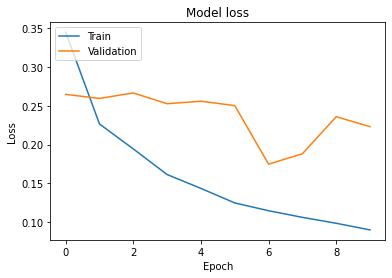

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [68]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[ 0.08293597,  0.17675751,  0.07046464, ...,  0.07454664,
         0.17601033,  0.03743119],
       [ 0.05004996,  0.08825929,  0.08982674, ...,  0.11793359,
         0.17173441,  0.07666671],
       [ 0.20500594,  0.27744043,  0.19330034, ...,  0.16493727,
         0.13414432,  0.02274517],
       ...,
       [ 0.05264341,  0.07126326,  0.12918922, ...,  0.13469353,
         0.08019671, -0.11903796],
       [ 0.14058924,  0.1720771 ,  0.10588333, ...,  0.12534335,
         0.19821556,  0.07917289],
       [ 0.16597089,  0.08729991,  0.0778758 , ...,  0.25256056,
         0.05965599, -0.12506199]], dtype=float32)]
[[[ 0.08293597  0.17675751  0.07046464 ...  0.07454664  0.17601033
    0.03743119]
  [ 0.05004996  0.08825929  0.08982674 ...  0.11793359  0.17173441
    0.07666671]
  [ 0.20500594  0.27744043  0.19330034 ...  0.16493727  0.13414432
    0.02274517]
  ...
  [ 0.05264341  0.07126326  0.12918922 ...  0.13469353  0.08019671
   -0.11903796]
  [ 0.14058924  0.1720771   0.10

#model softmax

1.------------------------xception---------------------------------

In [69]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda,Multiply
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = Xception(weights='imagenet', include_top=False)
#for i,layer in enumerate(base_model.layers):
    #print (i,layer.name)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
##input_age = Input(shape=(1,),dtype='float32',name='input3')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
f = Dense(256, activation='relu')(f)
#f = Dense(240)(f)
#y=Flatten()(input_age)
#multiplied = tf.keras.layers.Multiply()([f, y])
predictions =Dense(240, activation='softmax')(f)

  

model = Model(inputs=[input,input_gender], outputs=predictions)
#for i,layer in enumerate(model.layers):
    #print (i,layer.name)
model.summary()

Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m1.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 10, 10, 2048)
(None, 2, 2, 256)
(None, 1056)
Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, None, None,   20861480    ['input1[0][0]']                 
                                2048)                                                             
                                                                                                  
 conv2d_625 (Conv2D)            (None, 8, 8, 256)    4718848     ['xception[0][0]']               
                                       

Epoch 1/10
81/81 [==============================] - 55s 593ms/step - loss: 0.1993 - MAE: 0.1993 - val_loss: 0.2011 - val_MAE: 0.2011
Epoch 2/10
81/81 [==============================] - 46s 570ms/step - loss: 0.1983 - MAE: 0.1983 - val_loss: 0.2008 - val_MAE: 0.2008
Epoch 3/10
81/81 [==============================] - 47s 575ms/step - loss: 0.1979 - MAE: 0.1979 - val_loss: 0.2005 - val_MAE: 0.2005
Epoch 4/10
81/81 [==============================] - 46s 572ms/step - loss: 0.1977 - MAE: 0.1977 - val_loss: 0.2009 - val_MAE: 0.2009
Epoch 5/10
81/81 [==============================] - 47s 575ms/step - loss: 0.1976 - MAE: 0.1976 - val_loss: 0.2005 - val_MAE: 0.2005
Epoch 6/10
81/81 [==============================] - 46s 574ms/step - loss: 0.1975 - MAE: 0.1975 - val_loss: 0.2004 - val_MAE: 0.2004
Epoch 7/10
81/81 [==============================] - 46s 570ms/step - loss: 0.1974 - MAE: 0.1974 - val_loss: 0.2006 - val_MAE: 0.2006
Epoch 8/10
81/81 [==============================] - 46s 573ms/step - 

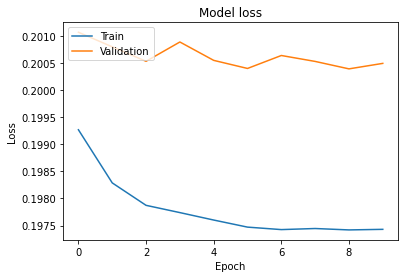

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [71]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[9.4891226e-07, 2.8923953e-06, 4.7349199e-06, ..., 2.4842434e-06,
        1.2845163e-06, 1.1907329e-06],
       [2.4635803e-08, 8.6834842e-07, 1.1894541e-07, ..., 3.0148915e-06,
        2.6784932e-07, 1.0089924e-07],
       [1.3487412e-08, 9.4510291e-08, 5.5991276e-08, ..., 2.9040025e-08,
        5.1550451e-08, 6.7182995e-08],
       ...,
       [1.2038801e-09, 3.3215308e-08, 3.1180685e-09, ..., 6.3206591e-09,
        4.5522528e-09, 1.4896797e-08],
       [2.0030442e-09, 2.3144041e-08, 1.0462663e-08, ..., 3.5432268e-09,
        1.0816279e-08, 1.5984815e-08],
       [1.6339995e-07, 1.3205415e-07, 2.7566278e-08, ..., 3.0069891e-08,
        1.4694220e-06, 1.6573242e-07]], dtype=float32)]
[[[9.4891226e-07 2.8923953e-06 4.7349199e-06 ... 2.4842434e-06
   1.2845163e-06 1.1907329e-06]
  [2.4635803e-08 8.6834842e-07 1.1894541e-07 ... 3.0148915e-06
   2.6784932e-07 1.0089924e-07]
  [1.3487412e-08 9.4510291e-08 5.5991276e-08 ... 2.9040025e-08
   5.1550451e-08 6.7182995e-08]
  ...
  [1.20

2.------------------------inception---------------------------------

In [72]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = InceptionV3(weights='imagenet', include_top=False)

input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240, activation='softmax')(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m2.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 8, 8, 2048)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 28s 263ms/step - loss: 0.2018 - MAE: 0.2018 - val_loss: 0.2034 - val_MAE: 0.2034
Epoch 2/10
81/81 [==============================] - 20s 250ms/step - loss: 0.2005 - MAE: 0.2005 - val_loss: 0.2025 - val_MAE: 0.2025
Epoch 3/10
81/81 [==============================] - 20s 247ms/step - loss: 0.1997 - MAE: 0.1997 - val_loss: 0.2026 - val_MAE: 0.2026
Epoch 4/10
81/81 [==============================] - 20s 244ms/step - loss: 0.1996 - MAE: 0.1996 - val_loss: 0.2024 - val_MAE: 0.2024
Epoch 5/10
81/81 [==============================] - 20s 244ms/step - loss: 0.1996 - MAE: 0.1996 - val_loss: 0.2022 - val_MAE: 0.2022
Epoch 6/10
81/81 [==============================] - 20s 246ms/step - loss: 0.1993 - MAE: 0.1993 - val_loss: 0.2020 - val_MAE: 0.2020
Epoch 7/10
81/81 [==============================] - 20s 247ms/step - loss: 0.1993 - MAE: 0.1993 - val_loss: 0.2020 - val_MAE: 0.2020
Epoch 8/10
81/81 [=

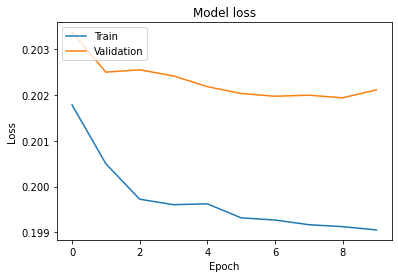

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [74]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[7.4941681e-07, 8.1179940e-07, 4.2071841e-07, ..., 3.1885390e-06,
        5.4319088e-07, 5.1626262e-07],
       [1.5133453e-06, 1.4808794e-06, 1.2743050e-06, ..., 1.3978076e-05,
        1.8049949e-06, 1.4289338e-06],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.5170769e-08, 8.3344054e-07, 6.5145834e-08, ..., 1.2714827e-06,
        6.1959518e-08, 7.8044974e-07]], dtype=float32)]
[[[7.4941681e-07 8.1179940e-07 4.2071841e-07 ... 3.1885390e-06
   5.4319088e-07 5.1626262e-07]
  [1.5133453e-06 1.4808794e-06 1.2743050e-06 ... 1.3978076e-05
   1.8049949e-06 1.4289338e-06]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.00

3.------------------------resnet---------------------------------

In [75]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = ResNet50(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240, activation='softmax')(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m3.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 10, 10, 2048)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 35s 342ms/step - loss: 0.2007 - MAE: 0.2007 - val_loss: 0.2042 - val_MAE: 0.2042
Epoch 2/10
81/81 [==============================] - 27s 332ms/step - loss: 0.2011 - MAE: 0.2011 - val_loss: 0.2046 - val_MAE: 0.2046
Epoch 3/10
81/81 [==============================] - 26s 327ms/step - loss: 0.2010 - MAE: 0.2010 - val_loss: 0.2050 - val_MAE: 0.2050
Epoch 4/10
81/81 [==============================] - 26s 327ms/step - loss: 0.2011 - MAE: 0.2011 - val_loss: 0.2049 - val_MAE: 0.2049
Epoch 5/10
81/81 [==============================] - 27s 328ms/step - loss: 0.1999 - MAE: 0.1999 - val_loss: 0.2036 - val_MAE: 0.2036
Epoch 6/10
81/81 [==============================] - 27s 332ms/step - loss: 0.1996 - MAE: 0.1996 - val_loss: 0.2039 - val_MAE: 0.2039
Epoch 7/10
81/81 [==============================] - 26s 327ms/step - loss: 0.1994 - MAE: 0.1994 - val_loss: 0.2037 - val_MAE: 0.2037
Epoch 8/10
81/81 

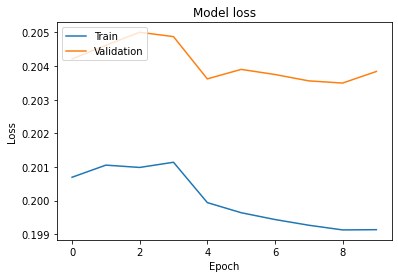

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [77]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[8.4106450e-04, 2.4986849e-04, 1.7425806e-04, ..., 2.1512235e-04,
        2.1568252e-04, 2.9378341e-04],
       [4.3559908e-06, 1.6407425e-08, 7.5331013e-09, ..., 8.8526786e-09,
        9.4508650e-08, 4.1530271e-07],
       [7.2349602e-04, 1.6041767e-04, 1.8990744e-04, ..., 1.3263151e-04,
        1.4622054e-04, 2.8897930e-04],
       ...,
       [4.1059675e-06, 4.0249734e-08, 6.0235479e-08, ..., 6.3975207e-08,
        5.7443854e-09, 2.4772524e-07],
       [3.7929299e-04, 4.2074811e-05, 3.5861151e-05, ..., 2.7421691e-05,
        3.1363390e-05, 8.4080115e-05],
       [2.4421425e-25, 4.1089276e-33, 6.8216440e-34, ..., 4.1483365e-31,
        2.2029757e-35, 9.0640994e-28]], dtype=float32)]
[[[8.4106450e-04 2.4986849e-04 1.7425806e-04 ... 2.1512235e-04
   2.1568252e-04 2.9378341e-04]
  [4.3559908e-06 1.6407425e-08 7.5331013e-09 ... 8.8526786e-09
   9.4508650e-08 4.1530271e-07]
  [7.2349602e-04 1.6041767e-04 1.8990744e-04 ... 1.3263151e-04
   1.4622054e-04 2.8897930e-04]
  ...
  [4.10

4.------------------------mobile---------------------------------

In [78]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240, activation='softmax')(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m4.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 9, 9, 1280)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 23s 225ms/step - loss: 0.2008 - MAE: 0.2008 - val_loss: 0.2053 - val_MAE: 0.2053
Epoch 2/10
81/81 [==============================] - 17s 213ms/step - loss: 0.2000 - MAE: 0.2000 - val_loss: 0.2044 - val_MAE: 0.2044
Epoch 3/10
81/81 [==============================] - 17s 214ms/step - loss: 0.1994 - MAE: 0.1994 - val_loss: 0.2051 - val_MAE: 0.2051
Epoch 4/10
81/81 [==============================] - 17s 212ms/step - loss: 0.1990 - MAE: 0.1990 - val_loss: 0.2049 - val_MAE: 0.2049
Epoch 5/10
81/81 [==============================] - 17s 212ms/step - loss: 0.1988 - MAE: 0.1988 - val_loss: 0.2040 - val_MAE: 0.2040
Epoch 6/10
81/81 [==============================] - 17s 212ms/step - loss: 0.1985 - MAE: 0.1985 - val_loss: 0.2034 - val_MAE: 0.2034
Epoch 7/10
81/81 [==============================] - 17s 213ms/step - loss: 0.1985 - MAE: 0.1985 - val_loss: 0.2036 - val_MAE: 0.2036
Epoch 8/10
81/81 [=

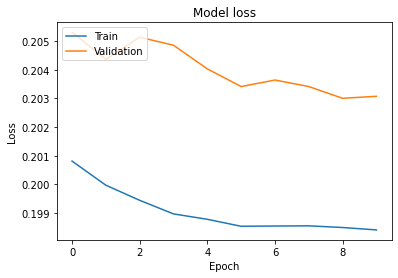

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [80]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[1.1318903e-08, 6.5689960e-07, 2.9319563e-07, ..., 3.6665973e-08,
        1.0954986e-06, 1.7072383e-08],
       [6.6492067e-10, 5.2808868e-09, 2.2312117e-09, ..., 2.9853606e-09,
        3.3780596e-09, 5.3673471e-08],
       [1.4750919e-08, 3.3438153e-07, 1.5289785e-07, ..., 2.1980198e-07,
        4.6108190e-07, 6.8110347e-07],
       ...,
       [1.9625995e-11, 5.9710464e-10, 2.2099501e-11, ..., 3.0456432e-10,
        6.6087280e-10, 1.1777670e-09],
       [2.2902868e-09, 7.5562276e-09, 2.8053209e-09, ..., 2.3414488e-09,
        2.2367471e-08, 5.3216245e-09],
       [1.0340713e-10, 5.4909900e-11, 2.0622835e-09, ..., 6.3907130e-11,
        8.6552889e-09, 5.0949861e-10]], dtype=float32)]
[[[1.1318903e-08 6.5689960e-07 2.9319563e-07 ... 3.6665973e-08
   1.0954986e-06 1.7072383e-08]
  [6.6492067e-10 5.2808868e-09 2.2312117e-09 ... 2.9853606e-09
   3.3780596e-09 5.3673471e-08]
  [1.4750919e-08 3.3438153e-07 1.5289785e-07 ... 2.1980198e-07
   4.6108190e-07 6.8110347e-07]
  ...
  [1.96

5.------------------------inres---------------------------------

In [81]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240, activation='softmax')(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m5.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 8, 8, 1536)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 70s 624ms/step - loss: 0.1999 - MAE: 0.1999 - val_loss: 0.2040 - val_MAE: 0.2040
Epoch 2/10
81/81 [==============================] - 47s 575ms/step - loss: 0.1991 - MAE: 0.1991 - val_loss: 0.2030 - val_MAE: 0.2030
Epoch 3/10
81/81 [==============================] - 47s 578ms/step - loss: 0.1991 - MAE: 0.1991 - val_loss: 0.2026 - val_MAE: 0.2026
Epoch 4/10
81/81 [==============================] - 47s 578ms/step - loss: 0.1989 - MAE: 0.1989 - val_loss: 0.2028 - val_MAE: 0.2028
Epoch 5/10
81/81 [==============================] - 47s 577ms/step - loss: 0.1986 - MAE: 0.1986 - val_loss: 0.2013 - val_MAE: 0.2013
Epoch 6/10
81/81 [==============================] - 47s 578ms/step - loss: 0.1985 - MAE: 0.1985 - val_loss: 0.2012 - val_MAE: 0.2012
Epoch 7/10
81/81 [==============================] - 47s 579ms/step - loss: 0.1982 - MAE: 0.1982 - val_loss: 0.2009 - val_MAE: 0.2009
Epoch 8/10
81/81 [=

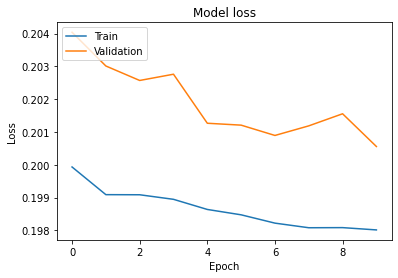

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [83]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[2.3788336e-06, 6.7455909e-07, 7.7066824e-07, ..., 6.8779269e-07,
        6.0832974e-07, 9.2546708e-07],
       [1.0366131e-06, 4.6914914e-07, 3.8728533e-07, ..., 3.2502589e-07,
        3.5266763e-07, 4.0278906e-07],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.1651903e-21, 3.2068739e-23, 1.1549404e-23, ..., 3.5504865e-22,
        5.0002694e-22, 1.7444061e-22],
       [5.0859819e-07, 1.7102984e-08, 1.4841250e-07, ..., 6.4311877e-08,
        1.8740140e-07, 1.7088740e-07]], dtype=float32)]
[[[2.3788336e-06 6.7455909e-07 7.7066824e-07 ... 6.8779269e-07
   6.0832974e-07 9.2546708e-07]
  [1.0366131e-06 4.6914914e-07 3.8728533e-07 ... 3.2502589e-07
   3.5266763e-07 4.0278906e-07]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.00

6.------------------------den201---------------------------------

In [84]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240, activation='softmax')(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m6.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 9, 9, 1920)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 65s 551ms/step - loss: 0.2013 - MAE: 0.2013 - val_loss: 0.2054 - val_MAE: 0.2054
Epoch 2/10
81/81 [==============================] - 41s 509ms/step - loss: 0.2013 - MAE: 0.2013 - val_loss: 0.2053 - val_MAE: 0.2053
Epoch 3/10
81/81 [==============================] - 41s 509ms/step - loss: 0.2008 - MAE: 0.2008 - val_loss: 0.2034 - val_MAE: 0.2034
Epoch 4/10
81/81 [==============================] - 41s 508ms/step - loss: 0.2002 - MAE: 0.2002 - val_loss: 0.2028 - val_MAE: 0.2028
Epoch 5/10
81/81 [==============================] - 41s 507ms/step - loss: 0.1999 - MAE: 0.1999 - val_loss: 0.2030 - val_MAE: 0.2030
Epoch 6/10
81/81 [==============================] - 41s 508ms/step - loss: 0.1996 - MAE: 0.1996 - val_loss: 0.2024 - val_MAE: 0.2024
Epoch 7/10
81/81 [==============================] - 41s 509ms/step - loss: 0.1994 - MAE: 0.1994 - val_loss: 0.2023 - val_MAE: 0.2023
Epoch 8/10
81/81 [=

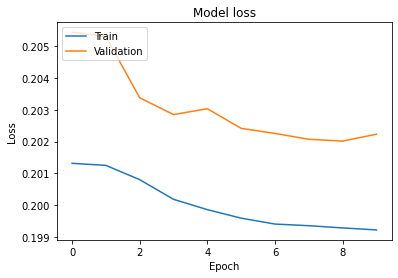

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [86]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[2.59895527e-09, 8.50693294e-09, 3.12975268e-09, ...,
        4.47390391e-09, 1.16687460e-08, 1.43051375e-08],
       [1.16844931e-05, 8.14675877e-06, 1.12506359e-05, ...,
        7.67087658e-06, 1.06423840e-05, 1.39758149e-05],
       [1.48457995e-19, 1.73351430e-17, 1.20408598e-18, ...,
        1.79343200e-19, 4.63629191e-18, 6.93017377e-18],
       ...,
       [9.05003550e-33, 3.60569186e-28, 4.88833616e-32, ...,
        3.64091596e-32, 3.16072534e-32, 2.39245202e-29],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.77958378e-07, 6.68254870e-07, 7.91967182e-07, ...,
        6.39296104e-07, 3.43311029e-07, 1.78675066e-06]], dtype=float32)]
[[[2.59895527e-09 8.50693294e-09 3.12975268e-09 ... 4.47390391e-09
   1.16687460e-08 1.43051375e-08]
  [1.16844931e-05 8.14675877e-06 1.12506359e-05 ... 7.67087658e-06
   1.06423840e-05 1.39758149e-05]
  [1.48457995e-19 1.73351430e-17 1.20408598e-18 ... 1.793432

7.------------------------eff---------------------------------

In [87]:
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB4

base_model = EfficientNetB4(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(32)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(5,5))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions =Dense(240, activation='softmax')(f)

model = Model(inputs=[input,input_gender], outputs=predictions)


Adam=keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])

model.summary
# Save weights after every epoch

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_m6.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=10)
#history = model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train],y_trains,batch_size=batch_size,epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valids), callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_tests, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#ShowAttentionV1(base_model,'/raid/chenchao/code/BoneAge/BoneAge/data/train/')

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)


(None, 9, 9, 1792)
(None, 2, 2, 256)
(None, 1056)
Epoch 1/10
81/81 [==============================] - 80s 746ms/step - loss: 0.2002 - MAE: 0.2002 - val_loss: 0.2064 - val_MAE: 0.2064
Epoch 2/10
81/81 [==============================] - 57s 701ms/step - loss: 0.1987 - MAE: 0.1987 - val_loss: 0.2064 - val_MAE: 0.2064
Epoch 3/10
81/81 [==============================] - 57s 702ms/step - loss: 0.1982 - MAE: 0.1982 - val_loss: 0.2063 - val_MAE: 0.2063
Epoch 4/10
81/81 [==============================] - 57s 705ms/step - loss: 0.1980 - MAE: 0.1980 - val_loss: 0.2063 - val_MAE: 0.2063
Epoch 5/10
81/81 [==============================] - 57s 703ms/step - loss: 0.1979 - MAE: 0.1979 - val_loss: 0.2063 - val_MAE: 0.2063
Epoch 6/10
81/81 [==============================] - 57s 702ms/step - loss: 0.1978 - MAE: 0.1978 - val_loss: 0.2064 - val_MAE: 0.2064
Epoch 7/10
81/81 [==============================] - 57s 700ms/step - loss: 0.1978 - MAE: 0.1978 - val_loss: 0.2052 - val_MAE: 0.2052
Epoch 8/10
81/81 [=

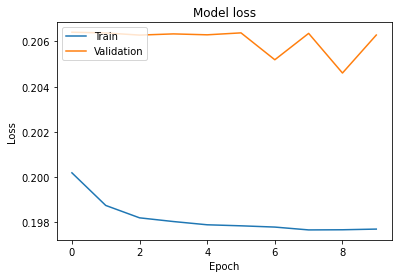

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [89]:
def TestMAE(model,test_data,test_label,test_gender):
    #print(test_label.type)
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[4].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    print(predictions)
    predictions = np.array(predictions)
    print(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE

#model.load_weights('/content/weights_m1.10-0.20.hdf5')
val=TestMAE(model,x_test,y_tests,gender_test)
print(val)
#gender_test.shape

[array([[2.4939854e-06, 8.8086344e-06, 5.5498122e-06, ..., 9.1921020e-06,
        7.7335008e-06, 3.0615465e-06],
       [2.3017960e-06, 9.1062548e-06, 6.0729785e-06, ..., 1.2568897e-05,
        7.1996019e-06, 3.3141721e-06],
       [2.0986261e-06, 8.6489399e-06, 4.7389658e-06, ..., 8.4543581e-06,
        6.5233216e-06, 2.6237203e-06],
       ...,
       [2.6993982e-06, 9.0505682e-06, 5.2427204e-06, ..., 1.1693144e-05,
        8.1068220e-06, 3.4872660e-06],
       [2.6195544e-06, 8.9553187e-06, 5.5379442e-06, ..., 9.5530177e-06,
        8.2469815e-06, 3.3537669e-06],
       [2.5254637e-06, 9.8320825e-06, 7.0860465e-06, ..., 1.0378721e-05,
        8.0219652e-06, 3.0855019e-06]], dtype=float32)]
[[[2.4939854e-06 8.8086344e-06 5.5498122e-06 ... 9.1921020e-06
   7.7335008e-06 3.0615465e-06]
  [2.3017960e-06 9.1062548e-06 6.0729785e-06 ... 1.2568897e-05
   7.1996019e-06 3.3141721e-06]
  [2.0986261e-06 8.6489399e-06 4.7389658e-06 ... 8.4543581e-06
   6.5233216e-06 2.6237203e-06]
  ...
  [2.69